

```
# This is formatted as code
```

#Anh làm


In [ ]:
import re
import networkx as nx

brand_sources = ["/content/HM_sustainability_report_2024.txt"]

external_sources = ["/content/lawsuit.txt"]

# Fetch texts per source for better traceability
source_texts = {}
for path in brand_sources + external_sources:
    with open(path, 'r', encoding='utf-8') as f:
        source_texts[path] = f.read()

# Step 2: Text Preprocessing
def preprocess_text(text):
    # Remove boilerplate (expanded patterns)
    text = re.sub(r'\bPage \d+\b|\bH&M Group\b|\bAnnual Report\b|\bSustainability Report\b|\b\d{4}\b|\bwww\.hmgroup\.com\b', '', text, flags=re.IGNORECASE)
    # Normalize terms (expanded)
    text = re.sub(r'\beco-friendly\b|\bsustainable\b|\bgreen\b|\bconscious\b', 'environmental claim', text, flags=re.IGNORECASE)
    text = re.sub(r'\bGHG\b|\bgreenhouse gas\b', 'greenhouse gas emissions', text, flags=re.IGNORECASE)
    text = re.sub(r'\bnet zero\b|\bnet-zero\b', 'net zero', text, flags=re.IGNORECASE)
    return text

# Preprocess separately
cleaned_brand_texts = {key: preprocess_text(source_texts[key]) for key in brand_sources if source_texts[key]}
cleaned_external_texts = {key: preprocess_text(source_texts[key]) for key in external_sources if source_texts[key]}

# Step 3: Entity & Relation Extraction - Aligned with ontology, more automated, removed Product and Material
def extract_entities_from_text(text):
    # Split into sentences
    sentence_pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s'
    sentences = re.split(sentence_pattern, text)

    # Claims: Declared sustainability assertions
    claim_keywords = ['committed to', 'aim to', 'focus on', 'reducing', 'cutting', 'decarbonizing', 'transitioning to', 'sustainably sourced', 'recycled materials', 'net zero', 'circular economy', 'minimizing impact', 'phasing out', 'supporting energy efficiency', 'respecting human rights', 'zero waste', 'leading change', 'made with organic', 'environmental claim']
    claims = list(set(sent.strip() for sent in sentences if sent.strip() and any(re.search(r'\b' + re.escape(kw) + r'\b', sent, re.IGNORECASE) for kw in claim_keywords)))

    # Certifications: Third-party verifications
    cert_patterns = r'(GOTS|OEKO-TEX|ZDHC|AFIRM|ISO 9001:2015|OECD|UN Guiding Principles|Fashion Pact|Textile Exchange|REACH|SVHC|RE100|SBTi|ISAE3000)'
    certifications = list(set(re.findall(cert_patterns, text, re.IGNORECASE)))

    # Violations: Contradictory facts or red-flag data
    violation_keywords = ['misleading', 'false', 'untrue', 'removed', 'scrutiny', 'lawsuit', 'alleging', 'investigation', 'high emissions', 'failure to meet']
    violations = list(set(sent.strip() for sent in sentences if sent.strip() and any(re.search(r'\b' + re.escape(kw) + r'\b', sent, re.IGNORECASE) for kw in violation_keywords)))
    # Add specific emission patterns
    emission_pattern = r'(?:Scope \d Emissions: \d+[,\d]* (?:metric tons|tonnes) CO2e)'
    violations += list(set(re.findall(emission_pattern, text, re.IGNORECASE | re.DOTALL)))

    # Flags: Resulting semantic assessments
    flag_patterns = r'(semantic inconsistency|verified claim|misleading marketing|greenwashing|inconsistent)'
    flags = list(set(flag.lower() for flag in re.findall(flag_patterns, text, re.IGNORECASE)))
    return claims, certifications, violations, flags

# Extract per source and aggregate uniquely, separately for brand and external
all_claims, all_certifications = set(), set()
brand_entities = {}
for source, text in cleaned_brand_texts.items():
    claims, certifications, _, _ = extract_entities_from_text(text)
    brand_entities[source] = (claims, certifications)
    all_claims.update(claims)
    all_certifications.update(certifications)

all_violations, all_flags = set(), set()
external_entities = {}
for source, text in cleaned_external_texts.items():
    _, _, violations, flags = extract_entities_from_text(text)
    external_entities[source] = (violations, flags)
    all_violations.update(violations)
    all_flags.update(flags)

print("Extracted Claims:", list(all_claims))
print("Extracted Certifications:", list(all_certifications))
print("Extracted Violations:", list(all_violations))
print("Extracted Flags:", list(all_flags))

# Step 4: Ontology & KG Construction
G = nx.DiGraph()

# Add Brand node
G.add_node("H&M", type="Brand")

# Add Source nodes
for source in list(cleaned_brand_texts.keys()) + list(cleaned_external_texts.keys()):
    G.add_node(source, type="Source")

# Add other nodes with unique IDs to avoid duplicates
claim_nodes = {claim: f"Claim_{i+1}" for i, claim in enumerate(all_claims)}
cert_nodes = {cert: cert for cert in all_certifications}  # Certifications use name as ID
violation_nodes = {violation: f"Violation_{i+1}" for i, violation in enumerate(all_violations)}
flag_nodes = {flag: f"Flag_{i+1}" for i, flag in enumerate(all_flags)}

# Add nodes to graph
for claim, node_id in claim_nodes.items():
    G.add_node(node_id, type="Claim", description=claim)
for cert in cert_nodes.values():
    G.add_node(cert, type="Certification")
for violation, node_id in violation_nodes.items():
    G.add_node(node_id, type="Violation", description=violation)
for flag, node_id in flag_nodes.items():
    G.add_node(node_id, type="Flag", description=flag)

# Add relations
# MAKES: Brand -> Claim (all claims made by H&M)
for node_id in claim_nodes.values():
    G.add_edge("H&M", node_id, relation="MAKES")

# APPEARS_IN: Claim -> Source (based on where extracted)
for source, entities in brand_entities.items():
    for claim in entities[0]:  # claims
        if claim in claim_nodes:
            G.add_edge(claim_nodes[claim], source, relation="APPEARS_IN")

# APPEARS_IN: Violation -> Source
for source, entities in external_entities.items():
    for violation in entities[0]:  # violations
        if violation in violation_nodes:
            G.add_edge(violation_nodes[violation], source, relation="APPEARS_IN")

# COMPLIES_WITH: Claim -> Certification (approximated by co-occurrence in source)
for source, entities in brand_entities.items():
    for claim in entities[0]:
        if claim in claim_nodes:
            for cert in entities[1]:  # certifications
                G.add_edge(claim_nodes[claim], cert_nodes[cert], relation="COMPLIES_WITH")

# VIOLATES: Claim -> Violation (rule-based: if claim has positive sustainability term and violation has negative)
positive_keywords = ['net zero', 'reducing', 'sustainably sourced', 'recycled']
negative_keywords = ['misleading', 'false', 'untrue', 'lawsuit', 'high emissions', 'failure']
for claim in all_claims:
    if any(kw in claim.lower() for kw in positive_keywords) and claim in claim_nodes:
        for violation in all_violations:
            if any(kw in violation.lower() for kw in negative_keywords) and violation in violation_nodes:
                G.add_edge(claim_nodes[claim], violation_nodes[violation], relation="VIOLATES")

# FLAGGED_AS: Claim -> Flag (similar rule-based linking)
for claim in all_claims:
    if claim in claim_nodes:
        for flag in all_flags:
            if flag in flag_nodes:
                G.add_edge(claim_nodes[claim], flag_nodes[flag], relation="FLAGGED_AS")

print("\nKG Stats: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# Print all entities and relations
print("\nEntities (Nodes):")
for node, data in G.nodes(data=True):
    print(f"{node}: {data}")

print("\nRelations (Edges):")
for u, v, data in G.edges(data=True):
    print(f"{u} -> {v}: {data}")

# Step 5: Semantic Querying - Detect inconsistencies via VIOLATES/FLAGGED_AS paths, considering certifications suppress inconsistencies
def detect_inconsistencies(graph):
    inconsistencies = []
    bad_flag_descriptions = {'semantic inconsistency', 'misleading marketing', 'greenwashing', 'inconsistent'}
    for claim_node in [n for n, d in graph.nodes(data=True) if d.get('type') == 'Claim']:
        # Check if claim has certification path (e.g., via COMPLIES_WITH)
        has_cert = any(nx.has_path(graph, claim_node, cert) for cert in cert_nodes.values())

        # Only flag if no certification
        if not has_cert:
            # Collect paths to violations
            for target_node in [n for n, d in graph.nodes(data=True) if d.get('type') == 'Violation']:
                if nx.has_path(graph, claim_node, target_node):
                    paths = list(nx.all_simple_paths(graph, claim_node, target_node, cutoff=3))
                    if paths:
                        inconsistencies.extend(paths)

            # Collect paths to bad flags
            for target_node in [n for n, d in graph.nodes(data=True) if d.get('type') == 'Flag' and d.get('description', '').lower() in bad_flag_descriptions]:
                if nx.has_path(graph, claim_node, target_node):
                    paths = list(nx.all_simple_paths(graph, claim_node, target_node, cutoff=3))
                    if paths:
                        inconsistencies.extend(paths)

    return inconsistencies, len(inconsistencies)

paths, score = detect_inconsistencies(G)
print("\nDetected Inconsistency Paths:")
if paths:
    for path in paths:
        formatted_path = []
        for node in path:
            node_type = G.nodes[node].get('type', 'Unknown')
            desc = G.nodes[node].get('description', node)
            formatted_path.append(f"{node_type}: '{desc}'")
        print(" -> ".join(formatted_path))
else:
    print("No inconsistencies detected.")
print("Inconsistency Score:", score)

# Ablation example: Remove COMPLIES_WITH edges and re-evaluate
original_score = score
complies_edges = [e for e in G.edges(data=True) if e[2].get('relation') == 'COMPLIES_WITH']
for u, v, _ in list(complies_edges):
    G.remove_edge(u, v)
ablated_paths, ablated_score = detect_inconsistencies(G)
print("\nAblation (without COMPLIES_WITH) Score:", ablated_score, "Delta:", ablated_score - original_score)

Extracted Claims: ['issues environmental claim financing in form of environmental claim and sustainability-linked bonds to align sustainability priorities with financial strategy and provide investors with transparency on investments and performance towards key sustainability targets.', 'Decrease result of continued efforts in phasing out on-site coal changes in supplier base local legislation and  pushing for increased electrification of steam production.', 'In   spent SEK 1.7 billion on decarbonisation activities across value chain for example replacing conventional materials with recycled or sustainably sourced materials which stand for bigger part of spend as well as phasing out fossil fuels and supporting energy efficiency initiatives.', 'Increasing resource efficiency and reducing dependence on material resource use and extraction will not only reduce negative impact on people and planet but also improve resilience of business model.', 'To address water scarcity risks  has set am

In [ ]:
!pip install sentence-transformers networkx

In [ ]:
import re
import networkx as nx
from sentence_transformers import SentenceTransformer, util
import torch

brand_sources = ["/content/HM_sustainability_report_2024.txt"]
external_sources = ["/content/lawsuit.txt"]

# Fetch texts per source for better traceability
source_texts = {}
for path in brand_sources + external_sources:
    with open(path, 'r', encoding='utf-8') as f:
        source_texts[path] = f.read()

# Step 2: Text Preprocessing
def preprocess_text(text):
    text = re.sub(r'\bPage \d+\b|\bH&M Group\b|\bAnnual Report\b|\bSustainability Report\b|\b\d{4}\b|\bwww\.hmgroup\.com\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\beco-friendly\b|\bsustainable\b|\bgreen\b|\bconscious\b', 'environmental claim', text, flags=re.IGNORECASE)
    text = re.sub(r'\bGHG\b|\bgreenhouse gas\b', 'greenhouse gas emissions', text, flags=re.IGNORECASE)
    text = re.sub(r'\bnet zero\b|\bnet-zero\b', 'net zero', text, flags=re.IGNORECASE)
    return text

cleaned_brand_texts = {key: preprocess_text(source_texts[key]) for key in brand_sources}
cleaned_external_texts = {key: preprocess_text(source_texts[key]) for key in external_sources}

# Step 3: Entity & Relation Extraction (Simplified)
def extract_entities_from_text(text):
    sentence_pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s'
    sentences = re.split(sentence_pattern, text)

    # Claims: Declared sustainability assertions
    claim_keywords = ['committed to', 'aim to', 'focus on', 'reducing', 'cutting', 'decarbonizing', 'transitioning to', 'sustainably sourced', 'recycled materials', 'net zero', 'circular economy', 'minimizing impact', 'phasing out', 'supporting energy efficiency', 'respecting human rights', 'zero waste', 'leading change', 'made with organic', 'environmental claim']
    claims = list(set(sent.strip() for sent in sentences if sent.strip() and any(re.search(r'\b' + re.escape(kw) + r'\b', sent, re.IGNORECASE) for kw in claim_keywords)))

    # Certifications: Third-party verifications
    cert_patterns = r'(GOTS|OEKO-TEX|ZDHC|AFIRM|ISO 9001:2015|OECD|UN Guiding Principles|Fashion Pact|Textile Exchange|REACH|SVHC|RE100|SBTi|ISAE3000)'
    certifications = list(set(re.findall(cert_patterns, text, re.IGNORECASE)))

    # Violations: Contradictory facts or allegations (merged with flags)
    violation_keywords = ['misleading', 'false', 'untrue', 'removed', 'scrutiny', 'lawsuit', 'alleging', 'investigation', 'high emissions', 'failure to meet', 'semantic inconsistency', 'misleading marketing', 'greenwashing', 'inconsistent']
    violations = list(set(sent.strip() for sent in sentences if sent.strip() and any(re.search(r'\b' + re.escape(kw) + r'\b', sent, re.IGNORECASE) for kw in violation_keywords)))

    return claims, certifications, violations

# Extract and aggregate entities
all_claims, all_certifications = set(), set()
brand_entities = {}
for source, text in cleaned_brand_texts.items():
    claims, certifications, _ = extract_entities_from_text(text)
    brand_entities[source] = (claims, certifications)
    all_claims.update(claims)
    all_certifications.update(certifications)

all_violations = set()
for source, text in cleaned_external_texts.items():
    _, _, violations = extract_entities_from_text(text)
    all_violations.update(violations)

print(f"Extracted {len(all_claims)} Claims.")
print(f"Extracted {len(all_certifications)} Certifications.")
print(f"Extracted {len(all_violations)} Violations.")

# Step 4: Ontology & KG Construction
G = nx.DiGraph()

# Add Brand and Source nodes
G.add_node("H&M", type="Brand")
for source in list(cleaned_brand_texts.keys()) + list(cleaned_external_texts.keys()):
    G.add_node(source, type="Source")

# Add entity nodes
claim_nodes = {claim: f"Claim_{i+1}" for i, claim in enumerate(all_claims)}
cert_nodes = {cert.upper(): cert.upper() for cert in all_certifications} # Standardize cert names
violation_nodes = {violation: f"Violation_{i+1}" for i, violation in enumerate(all_violations)}

for claim, node_id in claim_nodes.items():
    G.add_node(node_id, type="Claim", description=claim)
for cert in cert_nodes.values():
    G.add_node(cert, type="Certification")
for violation, node_id in violation_nodes.items():
    G.add_node(node_id, type="Violation", description=violation)

# Add relations: MAKES, APPEARS_IN, COMPLIES_WITH
# VIOLATES will be added in Step 5 based on semantic analysis
for node_id in claim_nodes.values():
    G.add_edge("H&M", node_id, relation="MAKES")

for source, (claims, certs) in brand_entities.items():
    for claim in claims:
        G.add_edge(claim_nodes[claim], source, relation="APPEARS_IN")
        for cert in certs:
             G.add_edge(claim_nodes[claim], cert_nodes[cert.upper()], relation="COMPLIES_WITH")

for source, text in cleaned_external_texts.items():
    _, _, violations = extract_entities_from_text(text)
    for violation in violations:
        if violation in violation_nodes:
            G.add_edge(violation_nodes[violation], source, relation="APPEARS_IN")

print(f"\nKG Initial Stats: Nodes = {G.number_of_nodes()}, Edges = {G.number_of_edges()}")


# Step 5: Semantic Querying - Detect inconsistencies
def detect_semantic_inconsistencies(graph, top_k=10):
    """
    Detects semantic inconsistencies between claims and violations using a sentence transformer model.
    The more opposite the meaning, the higher the score.
    Adds 'VIOLATES' edges to the graph for the top_k inconsistencies.
    """
    print("\n--- Starting Semantic Inconsistency Detection ---")

    # 1. Load a lightweight, powerful pretrained model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # 2. Prepare lists of claims and violations from the graph
    claims_map = {node_id: data['description'] for node_id, data in graph.nodes(data=True) if data.get('type') == 'Claim'}
    violations_map = {node_id: data['description'] for node_id, data in graph.nodes(data=True) if data.get('type') == 'Violation'}

    if not claims_map or not violations_map:
        print("Not enough claims or violations to perform analysis.")
        return []

    claim_ids = list(claims_map.keys())
    claim_texts = list(claims_map.values())
    violation_ids = list(violations_map.keys())
    violation_texts = list(violations_map.values())

    print(f"Analyzing {len(claim_texts)} claims vs. {len(violation_texts)} violations...")

    # 3. Generate embeddings
    claim_embeddings = model.encode(claim_texts, convert_to_tensor=True, show_progress_bar=True)
    violation_embeddings = model.encode(violation_texts, convert_to_tensor=True, show_progress_bar=True)

    # 4. Compute cosine similarity and derive inconsistency score
    cosine_scores = util.cos_sim(claim_embeddings, violation_embeddings)
    inconsistency_scores = 1 - cosine_scores

    # 5. Find the top_k pairs with the highest inconsistency scores
    results = []

    # Flatten and sort scores to find the top k
    all_scores = []
    for i in range(len(claim_texts)):
        for j in range(len(violation_texts)):
            all_scores.append({'score': inconsistency_scores[i][j].item(), 'claim_idx': i, 'violation_idx': j})

    # Sort by score in descending order and take the top k
    top_results = sorted(all_scores, key=lambda x: x['score'], reverse=True)[:top_k]

    print(f"\n--- Top {len(top_results)} Detected Inconsistencies ---")

    for i, res in enumerate(top_results):
        claim_idx = res['claim_idx']
        violation_idx = res['violation_idx']
        score = res['score']

        claim_id = claim_ids[claim_idx]
        claim_text = claim_texts[claim_idx]
        violation_id = violation_ids[violation_idx]
        violation_text = violation_texts[violation_idx]

        # Check for supporting certifications for the claim
        certifications = [v for u, v in graph.out_edges(claim_id) if graph.get_edge_data(u, v).get('relation') == 'COMPLIES_WITH']

        results.append({
            'claim': claim_text,
            'violation': violation_text,
            'score': score,
            'certifications': certifications
        })

        # Add the 'VIOLATES' edge to the graph with the score
        graph.add_edge(claim_id, violation_id, relation="VIOLATES", score=f"{score:.4f}")

        # Print the detailed output
        print(f"\n{i+1}. INCONSISTENCY (Score: {score:.4f})")
        print(f"  [+] CLAIM: '{claim_text}'")
        if certifications:
            print(f"      └── SUPPORTED BY: {', '.join(certifications)}")
        else:
            print(f"      └── SUPPORTED BY: None")
        print(f"  [-] REBUTTAL: '{violation_text}'")

    print("\nUpdated KG with 'VIOLATES' relations for top inconsistencies.")
    return results

# Run the detection
inconsistencies = detect_semantic_inconsistencies(G, top_k=10)

# Final KG stats
print(f"\nKG Final Stats: Nodes = {G.number_of_nodes()}, Edges = {G.number_of_edges()}")

# You can inspect the new 'VIOLATES' edges in the graph
print("\nNewly added 'VIOLATES' edges:")
for u, v, data in G.edges(data=True):
    if data.get('relation') == 'VIOLATES':
        print(f"'{G.nodes[u]['description'][:40]}...' -> '{G.nodes[v]['description'][:40]}...' (Score: {data['score']})")

#Bé sửa

In [ ]:
# -*- coding: utf-8 -*-
"""
H&M Environmental Claim Consistency — from scratch

Requirements satisfied:
- Keep long-form claims (full sentences) from brand sources; environment-only.
- Violations only from lawsuit sources (flags merged into violations).
- Domain classification for claims and violations.
- Nếu có certificate cho claim đó thì claim đó ở vùng an toàn, có thể được duyệt qua (nhưng vẫn phải in ra có violation nào không
để cân nhắc), Nếu không có Cert nào chứng minh được claim đó thì sẽ xem có violation nào trái với cái claim đó không.
- Safe-zone via domain-specific certifications; +1 inconsistency per claim when unsafe AND has domain-matched lawsuit violation.
- Full outputs: extracted entities, KG stats, and a detailed consistency report with paths.

Author: you :)
"""

import re
import networkx as nx

# =========================
# 0) INPUT SOURCES
# =========================
brand_sources = ["/content/HM_sustainability_report_2024.txt"]   # claims + certs ONLY from here
external_sources = ["/content/lawsuit.txt"]                      # violations ONLY from here

# =========================
# 1) LOAD FILES
# =========================
source_texts = {}
for path in brand_sources + external_sources:
    with open(path, "r", encoding="utf-8") as f:
        source_texts[path] = f.read()

# =========================
# 2) PREPROCESS (light)
# =========================
def preprocess_text(text: str) -> str:
    text = re.sub(r'\bPage \d+\b|www\.hmgroup\.com', ' ', text, flags=re.I)
    text = text.replace("\u00ad", "")  # soft hyphen
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_brand_texts = {p: preprocess_text(source_texts[p]) for p in brand_sources}
cleaned_external_texts = {p: preprocess_text(source_texts[p]) for p in external_sources}

# =========================
# 3) ENVIRONMENT DOMAINS & CERT WHITELIST
# =========================
# Domain regexes for ENV claims (long sentence)
CLAIM_DOMAIN_RX = {
    "climate": re.compile(r'(net[-\s]?zero|greenhouse\s+gas|ghg|scope\s*1\s*&?\s*2|scope\s*3|decarbon|carbon)\b', re.I),
    "renewable_energy": re.compile(r'\brenewable\s+(?:electricity|energy)\b', re.I),
    "chemicals_water": re.compile(r'\b(zdhc|mrsl|wastewater|effluent|etp|chemical|water)\b', re.I),
    "wood_forest": re.compile(r'\b(FSC|PEFC|wood|forest|deforest|cellulosic|MMCF|man-made\s+cellulosic|MMC F)\b', re.I),
    "materials_textile": re.compile(r'\b(material|textile|cotton|polyester|recycled|sustainably\s+sourced|Textile\s+Exchange|GOTS|RWS|RMS|GCS)\b', re.I),
    "circularity": re.compile(r'\b(circular|zero\s*waste|reuse|repair|recycling|close[-\s]*loop)\b', re.I),
}
# Violation domain regex (lawsuit)
VIOLATION_DOMAIN_RX = {
    "climate": re.compile(r'(carbon|emission|CO2e|greenhouse|scope\s*3|net\s*zero|high\s+emissions)\b', re.I),
    "renewable_energy": re.compile(r'(renewable|electricity|RE100)\b', re.I),
    "chemicals_water": re.compile(r'(ZDHC|MRSL|toxic|wastewater|water\s+pollution|discharge|ETP)\b', re.I),
    "wood_forest": re.compile(r'(FSC|PEFC|deforest|wood|forest|cellulosic|MMCF)\b', re.I),
    "materials_textile": re.compile(r'(material|textile|cotton|polyester|recycled|sustainably\s+sourced|close[-\s]*loop|recycling\s+program)\b', re.I),
    "circularity": re.compile(r'(circular|reuse|repair|recycling|landfill|close[-\s]*loop|greenwash)\b', re.I),
}
# Domain-specific certification whitelist (safe-zone)
CERT_WHITELIST = {
    "climate": {"SBTi"},
    "renewable_energy": {"RE100"},
    "chemicals_water": {"ZDHC", "MRSL"},
    "wood_forest": {"FSC", "PEFC"},
    "materials_textile": {"GOTS", "RWS", "RMS", "GCS", "Textile Exchange"},
    "circularity": set(),  # no specific cert
# Generic cert tokens to extract from brand text
CERT_TOKENS = [
    r'\bSBTI\b', r'\bRE100\b', r'\bZDHC\b', r'\bMRSL\b',
    r'\bFSC\b', r'\bPEFC\b', r'\bGOTS\b', r'\bRWS\b', r'\bRMS\b', r'\bGCS\b',
    r'Textile\s+Exchange'
]

# =========================
# 4) EXTRACTION
# =========================
def split_sentences(text: str):
    """Simple sentence splitter: '.', '?', '!' boundaries."""
    return re.split(r'(?<=[\.\!\?])\s+', text)

def classify_claim_domain(sentence: str) -> str or None:
    for dom, rx in CLAIM_DOMAIN_RX.items():
        if rx.search(sentence):
            return dom
    return None

def classify_violation_domain(sentence: str) -> str or None:
    for dom, rx in VIOLATION_DOMAIN_RX.items():
        if rx.search(sentence):
            return dom
    return None

def extract_env_claims_from_brand(text: str):
    """Return list of (claim_sentence, domain) for environment-only claims."""
    claims = []
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        dom = classify_claim_domain(sent)
        if dom is not None:
            claims.append((sent, dom))
    return claims

def extract_certs_from_brand(text: str):
    """Return set of certification names found (normalized)."""
    found = set()
    for pat in CERT_TOKENS:
        for m in re.finditer(pat, text, flags=re.I):
            token = m.group(0)
            if re.search(r'Textile\s+Exchange', token, re.I):
                found.add("Textile Exchange")
            else:
                found.add(token.upper())
    return found

def extract_violations_from_lawsuit(text: str):
    """Return list of (violation_sentence, domain) from lawsuit sources only, ENV-related."""
    out = []
    seen = set()
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        dom = classify_violation_domain(sent)
        if dom is None:
            continue
        key = sent.lower()
        if key in seen:
            continue
        seen.add(key)
        out.append((sent, dom))
    return out

# ---- Run extraction
brand_entities = {}  # src -> dict with 'claims': [(sent, dom)], 'certs': set()
all_claims = []      # list of (sent, dom, src)
all_certs = set()
for src, txt in cleaned_brand_texts.items():
    claims = extract_env_claims_from_brand(txt)
    certs = extract_certs_from_brand(txt)
    brand_entities[src] = {"claims": claims, "certs": certs}
    for c in claims:
        all_claims.append((c[0], c[1], src))
    all_certs |= certs

external_entities = {}  # src -> [(sent, dom)]
all_violations = []     # list of (sent, dom, src)
for src, txt in cleaned_external_texts.items():
    violations = extract_violations_from_lawsuit(txt)
    external_entities[src] = violations
    for v in violations:
        all_violations.append((v[0], v[1], src))

# ---- Print extracted entities
print("Extracted Claims:", [c[0] for c in all_claims])
print("Extracted Certifications:", sorted(list(all_certs)))
print("Extracted Violations:", (v[0] for v in all_violations))

# =========================
# 5) BUILD KNOWLEDGE GRAPH
# =========================
G = nx.DiGraph()

# Brand node
G.add_node("H&M", type="Brand")

# Source nodes
for src in brand_sources + external_sources:
    G.add_node(src, type="Source")

# Claim nodes
claim_nodes = {}  # id -> {text, domain}
for i, (sent, dom, src) in enumerate(all_claims, 1):
    cid = f"Claim_{i}"
    claim_nodes[cid] = {"text": sent, "domain": dom, "source": src}
    G.add_node(cid, type="Claim", description=sent, domain=dom)
    G.add_edge("H&M", cid, relation="MAKES")
    G.add_edge(cid, src, relation="APPEARS_IN")

# Certification nodes
cert_nodes = set()
# universe for env certs = union of whitelist sets (plus their case variants already normalized)
whitelist_universe = set().union(*CERT_WHITELIST.values())
for cert in sorted(all_certs):
    # keep only env-relevant certs (match whitelist names ignoring case)
    if cert in whitelist_universe:
        G.add_node(cert, type="Certification")
        cert_nodes.add(cert)

# Link COMPLIES_WITH when claim's domain allows that cert AND cert co-occurs in same brand source
def claim_allowed_certs(domain: str):
    return CERT_WHITELIST.get(domain, set())

for cid, info in claim_nodes.items():
    dom = info["domain"]
    allowed = claim_allowed_certs(dom)
    src = info["source"]
    src_certs = brand_entities[src]["certs"]
    for c in (src_certs & allowed):
        if c in cert_nodes:
            G.add_edge(cid, c, relation="COMPLIES_WITH")

# Violation nodes (lawsuit only)
violation_nodes = {}  # id -> {text, domain, source}
for i, (sent, dom, src) in enumerate(all_violations, 1):
    vid = f"Violation_{i}"
    violation_nodes[vid] = {"text": sent, "domain": dom, "source": src}
    G.add_node(vid, type="Violation", description=sent, domain=dom)
    G.add_edge(vid, src, relation="APPEARS_IN")

# VIOLATES edges: link claim -> violation if same domain (environment-only, lawsuit-only already ensured)
for cid, cinfo in claim_nodes.items():
    cdom = cinfo["domain"]
    for vid, vinfo in violation_nodes.items():
        if vinfo["domain"] == cdom:
            G.add_edge(cid, vid, relation="VIOLATES")

print("\nKG Stats: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# Optional: list nodes/edges (comment out if too verbose)
# for n, d in G.nodes(data=True): print(n, d)
# for u, v, d in G.edges(data=True): print(u, "->", v, d)

# =========================
# 6) CONSISTENCY PATH & REPORT
# =========================
def detect_inconsistencies(graph: nx.DiGraph, lawsuit_sources_list):
    """
    SAFE if claim has COMPLIES_WITH to a domain-allowed certification.
    If not SAFE and it has VIOLATES edge(s) to lawsuit violations (same domain), +1 inconsistency (one per claim).
    Returns:
      - paths: [["Brand::H&M", claim_node, vio_node], ...]
      - score: number of inconsistent claims
      - report: list of dict per claim (full, domain, allowed, evidence certs, violations (snippet + source), paths, safe/inconsistent)
    """
    lawsuit_sources = set(lawsuit_sources_list)
    paths = []
    score = 0
    report = []

    # Build helper map: violation node -> its sources
    vio_sources = {v: [t for _, t, ed in graph.out_edges(v, data=True) if ed.get("relation") == "APPEARS_IN"]
                   for v, d in graph.nodes(data=True) if d.get("type") == "Violation"}

    # Iterate claims
    for cid, cdata in [(n, d) for n, d in graph.nodes(data=True) if d.get("type") == "Claim"]:
        claim_text = cdata.get("description", "")
        domain = cdata.get("domain", "")
        allowed_certs = sorted(list(CERT_WHITELIST.get(domain, set())))

        # evidence certs (only domain-allowed)
        evidence_certs = sorted([
            tgt for _, tgt, ed in graph.out_edges(cid, data=True)
            if ed.get("relation") == "COMPLIES_WITH" and tgt in allowed_certs
        ])

        safe = len(evidence_certs) > 0

        # domain-matched violations (from lawsuit sources)
        matched_vios = []
        for _, v, ed in graph.out_edges(cid, data=True):
            if ed.get("relation") != "VIOLATES":
                continue
            # must come from lawsuit sources
            if not any(src in lawsuit_sources for src in vio_sources.get(v, [])):
                continue
            matched_vios.append(v)

        inconsistent = (not safe) and len(matched_vios) > 0
        if inconsistent:
            score += 1
            # pick one path for summary, keep all in report
            paths.append(["Brand::H&M", cid, matched_vios[0]])

        report.append({
            "claim_node": cid,
            "claim_text": claim_text,
            "domain": domain,
            "allowed_certs": allowed_certs,
            "evidence_certs": evidence_certs,
            "safe": safe,
            "inconsistent": inconsistent,
            "violations": [{
                "violation_node": v,
                "violation_snippet": graph.nodes[v].get("description", "")[:240].strip(),
                "sources": vio_sources.get(v, [])
            } for v in matched_vios],
            "paths": [["Brand::H&M", cid, v] for v in matched_vios]
        })

    return paths, score, report

paths, score, report = detect_inconsistencies(G, external_sources)

# =========================
# 7) OUTPUT — FULL REPORT
# =========================
print("\n=== CONSISTENCY REPORT (ENV ONLY) ===")
for r in report:
    print(f"\nCLAIM NODE: {r['claim_node']}")
    print(f"  Domain          : {r['domain']}")
    print(f"  Claim (full)    : {r['claim_text']}")
    print(f"  Allowed certs   : {r['allowed_certs']}")
    print(f"  Evidence certs  : {r['evidence_certs']}")
    print(f"  SAFE?           : {r['safe']}")
    print(f"  INCONSISTENT?   : {r['inconsistent']}")
    if r["violations"]:
        print("  Violations (domain-matched, from lawsuit):")
        for v in r["violations"]:
            print(f"    - {v['violation_node']} | {v['violation_snippet']}...")
            print(f"      Sources: {v['sources']}")
    if r["paths"]:
        print("  Paths:")
        for p in r["paths"]:
            v_snip = G.nodes[p[-1]].get("description", "")[:140].strip()
            print(f"    - {' -> '.join(map(str, p))} | VIO_SNIPPET: {v_snip}...")

print("\nDetected Inconsistency Paths (unique):")
if paths:
    for p in paths:
        v_snip = G.nodes[p[-1]].get("description", "")[:140].strip()
        print(" -> ".join(map(str, p)), f"| VIO_SNIPPET: {v_snip}...")
else:
    print("No inconsistencies detected.")
print("Inconsistency Score:", score)


Extracted Claims: ['Key impact areas include climate water chemicals and pollution land-use and biodiversity raw materials and resource use and people.', "H&M Group continuously engages with stakeholders across value chain to ensure material matters are identified prioritized and incorporated into company's business activities and procedures.", 'Upstream value chain includes sourcing processing production and transportation of materials and input goods such as cotton and wool required to produce goods.', 'Large part of negative environmental impact occurs in upstream value chain particularly during textile manufacturing processes which are resource intensive.', 'Downstream value chain includes use reuse resell recycling and disposal of clothes textiles and homeware.', 'Large part of environmental impact occurs in upstream value chain particularly during textile manufacturing processes such as dyeing and washing which are often energy and water intensive.', 'H&M Group recognises that bu

In [3]:
# -*- coding: utf-8 -*-
"""
H&M Environmental Claim Consistency — final logic version

- Claims: extracted from brand reports (long sentence, with domain).
- Certifications: extracted from brand reports, checked against whitelist.
- Violations: extracted from lawsuit texts, using keyword matching (no domain yet).
- SAFE if claim has at least one allowed certification; otherwise check domain-matched violations.
- Graph edges:
    Brand -> Claim (MAKES)
    Claim -> Cert (COMPLIES_WITH)
    Brand -> Violation (VIOLATES)
    Claim -> Violation (VIOLATES, only if domain matches)
"""

import re
import networkx as nx

# =========================
# 0) INPUT SOURCES
# =========================
brand_sources = ["/content/HM_sustainability_report_2024.txt"]
external_sources = ["/content/lawsuit.txt"]

# =========================
# 1) LOAD FILES
# =========================
source_texts = {}
for path in brand_sources + external_sources:
    with open(path, "r", encoding="utf-8") as f:
        source_texts[path] = f.read()

# =========================
# 2) PREPROCESS
# =========================
def preprocess_text(text: str) -> str:
    text = re.sub(r'\bPage \d+\b|www\.hmgroup\.com', ' ', text, flags=re.I)
    text = text.replace("\u00ad", "")
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_brand_texts = {p: preprocess_text(source_texts[p]) for p in brand_sources}
cleaned_external_texts = {p: preprocess_text(source_texts[p]) for p in external_sources}

# =========================
# 3) CONFIG
# =========================
CLAIM_DOMAIN_RX = {
    "climate": re.compile(r'(net[-\s]?zero|greenhouse\s+gas|ghg|scope\s*1\s*&?\s*2|scope\s*3|decarbon|carbon)\b', re.I),
    "renewable_energy": re.compile(r'\brenewable\s+(?:electricity|energy)\b', re.I),
    "chemicals_water": re.compile(r'\b(zdhc|mrsl|wastewater|effluent|etp|chemical|water)\b', re.I),
    "wood_forest": re.compile(r'\b(FSC|PEFC|wood|forest|cellulosic|MMCF)\b', re.I),
    "materials_textile": re.compile(r'\b(material|textile|cotton|polyester|recycled|sustainably\s+sourced|Textile\s+Exchange|GOTS|RWS|RMS|GCS)\b', re.I),
    "circularity": re.compile(r'\b(circular|zero\s*waste|reuse|repair|recycling|close[-\s]*loop)\b', re.I),
}

VIOLATION_DOMAIN_RX = CLAIM_DOMAIN_RX  # dùng chung classifier cho domain

CERT_WHITELIST = {
    "climate": {"SBTI"},
    "renewable_energy": {"RE100"},
    "chemicals_water": {"ZDHC", "MRSL"},
    "wood_forest": {"FSC", "PEFC"},
    "materials_textile": {"GOTS", "RWS", "RMS", "GCS", "TEXTILE EXCHANGE"},
    "circularity": set(),
}

CERT_TOKENS = [
    r'\bSBTI\b', r'\bRE100\b', r'\bZDHC\b', r'\bMRSL\b',
    r'\bFSC\b', r'\bPEFC\b', r'\bGOTS\b', r'\bRWS\b',
    r'\bRMS\b', r'\bGCS\b', r'Textile\s+Exchange'
]

violation_keywords = [
    'misleading', 'false', 'untrue', 'removed', 'scrutiny',
    'lawsuit', 'alleging', 'investigation', 'high emissions',
    'failure to meet', 'being sued', 'misrepresentation'
]

# =========================
# 4) EXTRACTION
# =========================
def split_sentences(text: str):
    return re.split(r'(?<=[\.\!\?])\s+', text)

def classify_claim_domain(sentence: str):
    for dom, rx in CLAIM_DOMAIN_RX.items():
        if rx.search(sentence):
            return dom
    return None

def classify_violation_domain(sentence: str):
    for dom, rx in VIOLATION_DOMAIN_RX.items():
        if rx.search(sentence):
            return dom
    return None

def extract_claims(text: str):
    out = []
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        dom = classify_claim_domain(sent)
        if dom:
            out.append((sent, dom))
    return out

def extract_certs(text: str):
    found = set()
    for pat in CERT_TOKENS:
        for m in re.finditer(pat, text, flags=re.I):
            tok = m.group(0)
            if re.search(r'Textile\s+Exchange', tok, re.I):
                found.add("TEXTILE EXCHANGE")
            else:
                found.add(tok.upper())
    return found

def extract_violations(text: str):
    out = []
    seen = set()
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        if any(re.search(r'\b' + re.escape(kw) + r'\b', sent, re.I) for kw in violation_keywords):
            if sent.lower() not in seen:
                seen.add(sent.lower())
                out.append(sent)
    return out

# ---- Run extraction
brand_entities, external_entities = {}, {}
all_claims, all_certs, all_violations = [], set(), []

for src, txt in cleaned_brand_texts.items():
    claims = extract_claims(txt)
    certs = extract_certs(txt)
    brand_entities[src] = {"claims": claims, "certs": certs}
    all_claims += [(c[0], c[1], src) for c in claims]
    all_certs |= certs

for src, txt in cleaned_external_texts.items():
    violations = extract_violations(txt)
    external_entities[src] = violations
    all_violations += [(v, src) for v in violations]

# ---- Print extracted
print("=== Extracted Entities ===")
print("Claims:", len(all_claims))
print("Certifications:", sorted(all_certs))
print("Violations:", len(all_violations))
for i, (v, s) in enumerate(all_violations, 1):
    print(f"  Violation_{i}: {v[:120]}... (src={s})")

# =========================
# 5) BUILD KG
# =========================
G = nx.DiGraph()
G.add_node("H&M", type="Brand")

for src in brand_sources + external_sources:
    G.add_node(src, type="Source")

# Claims
claim_nodes = {}
for i, (sent, dom, src) in enumerate(all_claims, 1):
    cid = f"Claim_{i}"
    claim_nodes[cid] = {"text": sent, "domain": dom, "src": src}
    G.add_node(cid, type="Claim", description=sent, domain=dom)
    G.add_edge("H&M", cid, relation="MAKES")
    G.add_edge(cid, src, relation="APPEARS_IN")

# Certifications
whitelist_universe = set().union(*CERT_WHITELIST.values())
for c in sorted(all_certs):
    if c in whitelist_universe:
        G.add_node(c, type="Certification")

for cid, info in claim_nodes.items():
    dom, src = info["domain"], info["src"]
    allowed = CERT_WHITELIST.get(dom, set())
    for c in (brand_entities[src]["certs"] & allowed):
        G.add_edge(cid, c, relation="COMPLIES_WITH")

# Violations
violation_nodes = {}
for i, (vtext, src) in enumerate(all_violations, 1):
    vid = f"Violation_{i}"
    violation_nodes[vid] = {"text": vtext, "src": src}
    G.add_node(vid, type="Violation", description=vtext)
    G.add_edge("H&M", vid, relation="VIOLATES")
    G.add_edge(vid, src, relation="APPEARS_IN")

# Claim->Violation (domain match at this stage)
for cid, cinfo in claim_nodes.items():
    cdom = cinfo["domain"]
    for vid, vinfo in violation_nodes.items():
        vdom = classify_violation_domain(vinfo["text"])
        if vdom == cdom:
            G.add_edge(cid, vid, relation="VIOLATES")

print("\nKG Stats: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# =========================
# 6) CONSISTENCY REPORT (full format)
# =========================
def detect_inconsistencies(G, lawsuit_sources):
    paths, score, report = [], 0, []
    # map violation -> sources
    vio_sources = {v: [t for _, t, ed in G.out_edges(v, data=True) if ed.get("relation")=="APPEARS_IN"]
                   for v,d in G.nodes(data=True) if d.get("type")=="Violation"}
    for cid, cdata in [(n,d) for n,d in G.nodes(data=True) if d.get("type")=="Claim"]:
        claim_text, domain = cdata["description"], cdata["domain"]
        allowed_certs = sorted(list(CERT_WHITELIST.get(domain, set())))
        evidence_certs = [
            tgt for _,tgt,ed in G.out_edges(cid, data=True)
            if ed["relation"]=="COMPLIES_WITH" and tgt in allowed_certs
        ]
        safe = len(evidence_certs)>0
        vios = [v for _,v,ed in G.out_edges(cid, data=True) if ed["relation"]=="VIOLATES"]
        inconsistent = (not safe) and len(vios)>0
        if inconsistent:
            score += 1
            paths.append(["Brand::H&M", cid, vios[0]])
        report.append({
            "claim_node": cid,
            "claim_text": claim_text,
            "domain": domain,
            "allowed_certs": allowed_certs,
            "evidence_certs": evidence_certs,
            "safe": safe,
            "inconsistent": inconsistent,
            "violations": [{
                "violation_node": v,
                "violation_snippet": G.nodes[v]["description"][:200],
                "sources": vio_sources.get(v, [])
            } for v in vios],
            "paths": [["Brand::H&M", cid, v] for v in vios]
        })
    return paths, score, report

paths, score, report = detect_inconsistencies(G, external_sources)

print("\n=== CONSISTENCY REPORT ===")
for r in report:
    print(f"\nCLAIM NODE: {r['claim_node']}")
    print(f"  Domain          : {r['domain']}")
    print(f"  Claim (full)    : {r['claim_text']}")
    print(f"  Allowed certs   : {r['allowed_certs']}")
    print(f"  Evidence certs  : {r['evidence_certs']}")
    print(f"  SAFE?           : {r['safe']}")
    print(f"  INCONSISTENT?   : {r['inconsistent']}")
    if r["violations"]:
        print("  Violations (from lawsuit):")
        for v in r["violations"]:
            print(f"    - {v['violation_node']} | {v['violation_snippet']}...")
            print(f"      Sources: {v['sources']}")
    if r["paths"]:
        print("  Paths:")
        for p in r["paths"]:
            print(f"    - {' -> '.join(p)}")

print("\nDetected Inconsistency Paths:")
for p in paths:
    print(" -> ".join(p))
print("Inconsistency Score:", score)



=== Extracted Entities ===
Claims: 239
Certifications: ['FSC', 'MRSL', 'RE100', 'RWS', 'SBTI', 'TEXTILE EXCHANGE', 'ZDHC']
Violations: 12
  Violation_1: H&M is Being Sued For “Misleading” Sustainability Marketing.... (src=/content/lawsuit.txt)
  Violation_2: Images: H&M H&M is being sued for '“false” and “misleading” sustainability marketing.... (src=/content/lawsuit.txt)
  Violation_3: In a class-action lawsuit filed on July 22nd, Plaintiff Chelsea Commodore, a New York state resident, alleges that despi... (src=/content/lawsuit.txt)
  Violation_4: Commodore alleges that among other things, H&M's sustainability labeling, marketing, and advertising is “designed to mis... (src=/content/lawsuit.txt)
  Violation_5: In addition to these profiles, the lawsuit alleges that H&M makes various misrepresentations regarding the sustainable n... (src=/content/lawsuit.txt)
  Violation_6: According to the lawsuit, H&M’s created illusion “that old clothes are simply turned into new garments, or that 

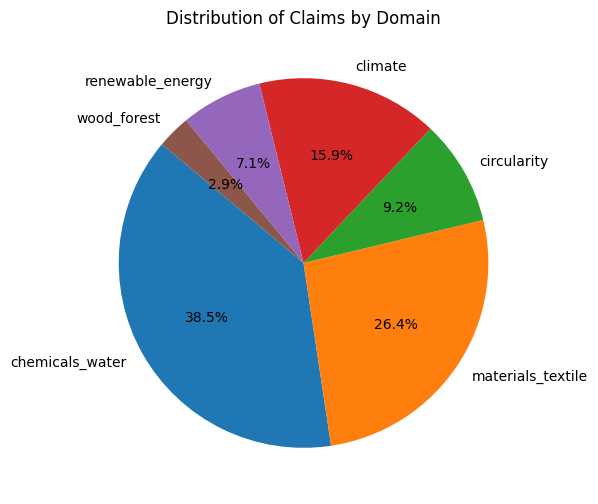

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# Count total claims per domain
domain_counts = Counter([r['domain'] for r in report])

# Count inconsistent claims per domain
inconsistent_counts = Counter([r['domain'] for r in report if r['inconsistent']])

# ----- Pie Chart 1: Distribution of claims per domain -----
labels1 = list(domain_counts.keys())
sizes1 = [domain_counts[d] for d in labels1]

plt.figure(figsize=(6,6))
plt.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Claims by Domain")
plt.show()
